# Movie Recommendations

MovieLens is a research site run by GroupLens Research at the University of Minnesota. MovieLens (https://movielens.org/) shares with community several datasets containing user's ratings of some movies. 

Our goal is to build a recommender system that will recommend user some movies that he probably would like to see based on his already collected ratings of other movies. For the purposes of this exercise we will focus on using Collaborative Filtering as our approach.

**Types of collaborative filtering techniques**
A lot of research has been done on collaborative filtering (CF), and most popular approaches are based on low-dimensional factor models (model based matrix factorization.

![alt text](https://miro.medium.com/max/1050/1*7uW5hLXztSu_FOmZOWpB6g.png)

**Memory-Based Collaborative Filtering** approaches can be divided into two main sections: user-item filtering and item-item filtering.

On the otherhand, **Model-based Collaborative Filtering** approach are developed using machine learning algorithms to predict a user’s rating of unrated items.

![alt text](https://cdn.codecentric.de/20210310095830/Fig1-1.png)





# Libraries

In [1]:
#install fuzzywuzzy

#FuzzyWuzzy is a library of Python which is used for string matching. 
#Fuzzy string matching is the process of finding strings that match a given pattern. 
#Basically it uses Levenshtein Distance to calculate the differences between sequences.

#!pip install fuzzywuzzy
#!pip install python-levenshtein


#Surprise is an open-source Python library for building recommender systems with explicit rating data. 
#install scikit surprise using terminal with code below

#conda install -c conda-forge scikit-surprise



In [2]:
# allows us to access dataframes
import pandas as pd

# specialized class for handling sparse matrices (compressed)
from scipy.sparse import csr_matrix

# Library for visualizing charts
import matplotlib.pylab as plt

# Fuzzy gives us access to functions that allow text scoring of similarities
from fuzzywuzzy import fuzz

# Gives us access to the unsupervised algorithm knn 
from sklearn.neighbors import NearestNeighbors

# Surprise is an easy-to-use Python scikit for recommender systems.
from surprise import SVD #SVD algorithm
from surprise import KNNBasic # Knn algorithm
from surprise import Dataset # Utility for loading datasets
from surprise import Reader # Allows surprise to interpret the ratings
from surprise.model_selection import cross_validate # cross validation utility


# Exploration

In [3]:
# https://grouplens.org/datasets/movielens
#https://files.grouplens.org/datasets/movielens/ml-25m.zip
movies_df = pd.read_csv("data/ml-25m/movies.csv")
movies_df.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [4]:
movies_df.shape

(62423, 3)

In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df = pd.read_csv("data/ml-25m/ratings.csv")
ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [7]:
ratings_df.shape

(25000095, 4)

In [8]:
num_users = len(ratings_df.userId.unique())
num_items = len(ratings_df.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 162541 unique users and 59047 unique movies in this data set


In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Text(0.5, 1.0, 'Count of Movie Ratings per User Id')

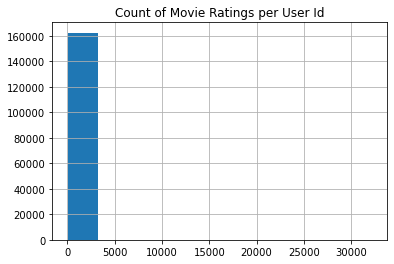

In [10]:
ratings_df[['userId','movieId']].groupby(['userId']).count().hist()
plt.title("Count of Movie Ratings per User Id")


#most of the user have XX number of ratings

In [11]:
ratings_df[['userId','movieId']].groupby(['userId']).count().describe()

#there are 162k unique users
#what else can we say about the users?

,movieId
count,162541.000000
mean,153.807932
std,268.047590
min,20.000000
25%,36.000000
50%,71.000000
75%,162.000000
max,32202.000000


Text(0.5, 1.0, 'Count of User Ratings per Movie Id')

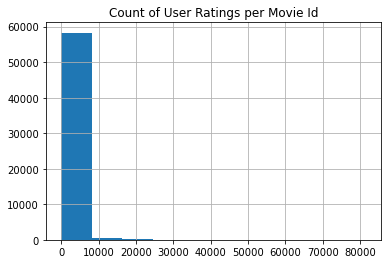

In [12]:
ratings_df[['userId','movieId']].groupby(['movieId']).count().hist()
plt.title("Count of User Ratings per Movie Id")

In [13]:
ratings_df[['userId','movieId']].groupby(['movieId']).count().describe()

,userId
count,59047.000000
mean,423.393144
std,2477.885821
min,1.000000
25%,2.000000
50%,6.000000
75%,36.000000
max,81491.000000


In [14]:
# based on this we can identify a threshold for amount of ratings to use per user/movie 
# ie. what is a popular movie? an active user? 
# Feel free to make this more or less restrictive as your model requires

<AxesSubplot:title={'center':'Count of Rating Score'}>

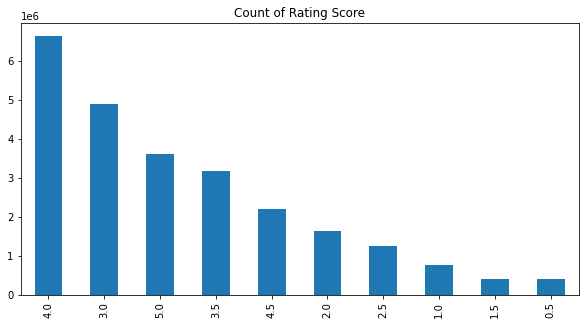

In [15]:
ratings_df['rating'].value_counts().plot.bar(title="Count of Rating Score",figsize=(10,5))

#what can we say about the ratings scores?

# Preprocessing

In [16]:
# Given some of our findings, let's try to optimize our dataset by filtering to only the data that we need

#why do we do this?

popularity_thres = 1 #this is the minimum number of ratings per movie

movie_rating_cnt_df = ratings_df[['userId','movieId']].groupby(['movieId']).count()
popular_movies_df = movie_rating_cnt_df[movie_rating_cnt_df['userId']>=popularity_thres]


filtered_pop_movies_df = ratings_df[ratings_df.index.isin(popular_movies_df.index.values)]
print('shape of original ratings data: ', ratings_df.shape)
print('shape of ratings data after dropping unpopular movies: ', filtered_pop_movies_df.shape)

shape of original ratings data:  (25000095, 4)
shape of ratings data after dropping unpopular movies:  (59047, 4)


In [17]:
ratings_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [18]:
filtered_pop_movies_df

,userId,movieId,rating,timestamp
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
...,...,...,...,...
209157,1480,1091,1.5,1562725592
209159,1480,1097,2.5,1557808920
209163,1480,1136,3.5,1557795363
209169,1480,1200,5.0,1557797113


In [19]:
#filtering for active users
ratings_thres = 2 
max_thres= 500

active_users_cnt_df = ratings_df[['userId','movieId']].groupby(['userId']).count()
#active_users_df = active_users_cnt_df[active_users_cnt_df['movieId']>=ratings_thres]

active_users_df = active_users_cnt_df[(active_users_cnt_df['movieId']>=ratings_thres)& (active_users_cnt_df['movieId']< max_thres) ]
#display(active_users_df) 

filtered_popular_active_df = filtered_pop_movies_df[filtered_pop_movies_df.index.isin(active_users_df.index.values)]
print('shape of original ratings data: ', filtered_pop_movies_df.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', filtered_popular_active_df.shape)

shape of original ratings data:  (59047, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (37025, 4)


In [20]:
# Let's transform this into a movie-user pivot table
# Let's join them up first using a left join operation on movieId

filtered_movie_ratings_merged_df = pd.merge(filtered_popular_active_df,movies_df, how='left', on=['movieId'])
filtered_movie_ratings_merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
1,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
2,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance
3,1,1088,4.0,1147868495,Dirty Dancing (1987),Drama|Musical|Romance
4,1,1175,3.5,1147868826,Delicatessen (1991),Comedy|Drama|Romance


In [21]:
# Now let's pivot the dataframe such that it will have movieId as the index, and userId as columns
filtered_movie_ratings_df = pd.pivot(filtered_movie_ratings_merged_df,index='movieId', columns='userId', values='rating').fillna(0)
filtered_movie_ratings_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
filtered_movie_ratings_df.shape

(6539, 984)

In [23]:
#Matrices that contain mostly zero values are called sparse,
#distinct from matrices where most of the values are non-zero, called dense.

#It is computationally expensive to represent and work with sparse matrices as though they are dense, 
#and much improvement in performance can be achieved by using representations and operations 
#that specifically handle the matrix sparsity.

# Now given that this is a sparse matrix, we will use scipy which has a matrix class
# that is optimized to handle sparse matrix objects

movie_ratings_mat = csr_matrix(filtered_popular_active_df.values)
movie_ratings_mat

# this will be used as input to the model

<37025x4 sparse matrix of type '<class 'numpy.float64'>'
	with 148100 stored elements in Compressed Sparse Row format>

# Memory-based Approach
## Using KNN to estimate distance

Here we will use KNN, which is an unsupervised learning model, in which a data point is classified by a majority vote of its neighbors, with the data point being assigned to the class most common amongst its k-nearest neighbors, as measured by a distance function (these can be of any kind depending upon your data being continuous or categorical). If k = 1, then the data point is simply assigned to the class of its nearest neighbor—i.e., itself.

In [24]:
# Metric is the distance algorithm to be used. You can find more choices here: 
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric

# algorithm is the type of tree search used by the model
# neighbors it the amount of neighbors identified
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit
model_knn.fit(movie_ratings_mat)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

KNN does not make any assumptions on the underlying data distribution but it relies on item feature similarity. When KNN makes inference about a movie, KNN will calculate the “distance” between the target movie and every other movie in its database, then it ranks its distances and returns the top K nearest neighbor movies as the most similar movie recommendations.

![alt text](https://miro.medium.com/max/975/1*OyYyr9qY-w8RkaRh2TKo0w.png)

In [25]:

# Let's create a movie title index that we can use later to retrieve titles based on index of our filtered dataset
# this results to a dictionary with the said mapping
movie_to_index = {movie: i for i, movie in enumerate(list(movies_df.set_index('movieId').loc[filtered_popular_active_df.index].title))}
movie_to_index

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Waiting to Exhale (1995)': 2,
 'Father of the Bride Part II (1995)': 3,
 'Heat (1995)': 4,
 'Sabrina (1995)': 5,
 'Tom and Huck (1995)': 6,
 'Sudden Death (1995)': 7,
 'GoldenEye (1995)': 8,
 'American President, The (1995)': 9,
 'Balto (1995)': 10,
 'Nixon (1995)': 11,
 'Cutthroat Island (1995)': 12,
 'Casino (1995)': 13,
 'Sense and Sensibility (1995)': 14,
 'Four Rooms (1995)': 15,
 'Ace Ventura: When Nature Calls (1995)': 16,
 'Money Train (1995)': 17,
 'Get Shorty (1995)': 18,
 'Copycat (1995)': 19,
 'Assassins (1995)': 20,
 'Powder (1995)': 21,
 'Leaving Las Vegas (1995)': 22,
 'Othello (1995)': 23,
 'Now and Then (1995)': 24,
 'Persuasion (1995)': 25,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 26,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 27,
 'Dangerous Minds (1995)': 28,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 29,
 'Wings of Courage (1995)': 30,
 'Babe (1995)': 31,
 'Carrington (1995)

In [26]:
# Let's create a function that will give us the nearest movie title based on the nearest text input

def get_movie_title(title):

    tmp_list = []
    # Let's take our movie to index items and iterate thru them to find the nearest 'similar' title
    for movie_title,idx in movie_to_index.items():
        # ratio is a function that give's a score on how "similar" two words are
        # the higher the score, the more similar they are
        ratio = fuzz.ratio(title.lower(),movie_title.lower())

        # we will use 60 as our cut off
        if(ratio>=60):
            tmp_dict = {"idx":idx,"title":movie_title, "ratio":ratio}
            tmp_list.append(tmp_dict)
    
    # If we don't get anything, return blank
    if(tmp_list == []):
        return None
    
    # We will store all similar titles and return a dataframe sorted in descending order of ratio
    tmp_df = pd.DataFrame(tmp_list)
    tmp_df = tmp_df.sort_values("ratio", ascending=False)
    return tmp_df



In [31]:
# Let's try it out
fav_movie = "clueless"
print('You have input movie:', fav_movie)
movie_matches_df = get_movie_title(fav_movie)
movie_matches_df

You have input movie: clueless


,idx,title,ratio
0,36,Clueless (1995),70


# Let's Recommend!

In [32]:
print("Let's start making recommendations!...")

if(movie_matches_df is  None):
    print("No Matching movies :(")
else:

    # We will provide the indices of the matching movies to filter the matrix and give our starting location
    input_movies = movie_ratings_mat[movie_matches_df.idx.values]

    # Indicate the top recommendations we want to get (how many neighbors should we find?)
    top_recommendations = 10

    # model will return a list of distances and indices
    distances, indices = model_knn.kneighbors(input_movies, n_neighbors=top_recommendations+1)

    # let's create a dictionary that  will allow us to retrieve the movie name using the index
    reverse_mapper = {v: k for k, v in movie_to_index.items()}

    # let's print the output
    tmp_df = pd.DataFrame()
    tmp_df['Distances'] = (distances).reshape(1,11)[0]
    tmp_df['Indices'] = (indices).reshape(1,11)[0]
    tmp_df['Title'] = tmp_df['Indices'].apply(lambda x: reverse_mapper[x])

    print("Our recommendations based on: ",fav_movie)
    
    # dispaly is a jupyter only command to present a dataframe
    display(tmp_df.sort_values('Distances'))

Let's start making recommendations!...
Our recommendations based on:  clueless


,Distances,Indices,Title
0,0.000000e+00,2434,"Curse of Frankenstein, The (1957)"
1,0.000000e+00,35,It Takes Two (1995)
2,0.000000e+00,36,Clueless (1995)
3,2.220446e-16,2433,Frankenstein Meets the Wolf Man (1943)
4,2.220446e-16,206,Boys on the Side (1995)
5,2.220446e-16,207,"Cure, The (1995)"
6,4.440892e-16,4485,Burnt Money (Plata Quemada) (2000)
7,5.551115e-16,4484,Bangkok Dangerous (2000)
8,5.551115e-16,4486,Dancing at the Blue Iguana (2000)
9,6.661338e-16,2442,It Came from Beneath the Sea (1955)


In [33]:
# Let's use surprise library to get a measure of our knn model's RMSE metric

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

# We'll train a knn model in surprise using our same data set
knnbasic = KNNBasic()

# Run 5-fold cross-validation and print results.
knn_results = cross_validate(knnbasic, data, measures=['RMSE'], cv=5, verbose=True)
knn_results
# Smaller RMSE means our model is able to give better recommendation

#how do we try other knn models?

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0128  1.0038  1.0103  1.0077  1.0092  1.0088  0.0030  
Fit time          0.05    0.04    0.03    0.04    0.03    0.04    0.01    
Test time         0.16    0.16    0.16    0.16    0.16    0.16    0.00    


{'test_rmse': array([1.01281779, 1.00378958, 1.01029116, 1.00771984, 1.00919701]),
 'fit_time': (0.0538630485534668,
  0.04183387756347656,
  0.032073259353637695,
  0.03668808937072754,
  0.03165793418884277),
 'test_time': (0.16377592086791992,
  0.16489791870117188,
  0.1587529182434082,
  0.1605546474456787,
  0.1607990264892578)}

# Model based approach

To Make things much more easier, we will be using the Surprise scikit which specializes in recommender models.

Continuing our Collaborative Filtering example, we will now use a model based approach via SVD (Singular Value Decomposition), as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization [salakhutdinov2008a].

Supplementary reading for SVD: https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d

SVD vs PCA https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

"From a simplified perspective, PCA transforms data linearly into new properties that are not correlated with each other. For ML, positioning PCA as feature extraction may allow us to explore its potential better than dimension reduction.
What is the difference between SVD and PCA? SVD gives you the whole nine-yard of diagonalizing a matrix into special matrices that are easy to manipulate and to analyze. It lay down the foundation to untangle data into independent components. PCA skips less significant components. Obviously, we can use SVD to find PCA by truncating the less important basis vectors in the original SVD matrix"

In [34]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results.
svd_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
svd_results
# Smaller RMSE means our model is able to give better recommendation

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9056  0.8925  0.9087  0.9030  0.8988  0.9017  0.0056  
Fit time          1.36    1.37    1.33    1.33    1.33    1.34    0.02    
Test time         0.03    0.10    0.03    0.03    0.03    0.04    0.03    


{'test_rmse': array([0.9055522 , 0.89245656, 0.90865245, 0.9030152 , 0.89881895]),
 'fit_time': (1.3561079502105713,
  1.3726258277893066,
  1.327652931213379,
  1.3320660591125488,
  1.32551908493042),
 'test_time': (0.03089618682861328,
  0.10496187210083008,
  0.029278993606567383,
  0.029575109481811523,
  0.028975248336791992)}

# Let's try to predict

In [35]:
# User rated 4
uid = str(1)  

# Movie: Grumpier Old Men (1995)
iid = str(3)  

#Get the prediction for the specific users and movie.
print("Prediction for rating: ")
pred = algo.predict(uid, iid, r_ui=4, verbose=True)
pred

Prediction for rating: 
user: 1          item: 3          r_ui = 4.00   est = 3.57   {'was_impossible': False}


Prediction(uid='1', iid='3', r_ui=4, est=3.572923700202566, details={'was_impossible': False})

In [36]:
# Our model was able to predict that the user (1) will rate the movie (3) a score of 3.7875 (4)

# Let's compare the two using RMSE

In [37]:
metric_df = pd.DataFrame()
metric_df['knn'] = knn_results['test_rmse']
metric_df['svd'] = svd_results['test_rmse']

tmp_dict1 = {'knn':metric_df['knn'].mean(),'svd':metric_df['svd'].mean()}
tmp_dict2 = {'knn':metric_df['knn'].std(),'svd':metric_df['svd'].std()}

metric_df = metric_df.append(tmp_dict1,ignore_index=True)
metric_df = metric_df.append(tmp_dict2,ignore_index=True)
metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
metric_df


,knn,svd
Fold 1,1.012818,0.905552
Fold 2,1.003790,0.892457
Fold 3,1.010291,0.908652
Fold 4,1.007720,0.903015
Fold 5,1.009197,0.898819
Mean,1.008763,0.901699
Std,0.003346,0.006298


# Top n predictions and the hit rate

In [38]:
from collections import defaultdict

# accept list of predictions and n of top n
#this is like our scoring algorithm for reco engines

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # top_n = is a dictionary to map rating to a userid as key
        # est = predicted rating
        # iid = movie id
        # uid = user id
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        
        # x[1] refers to the est score, which means sort highest to lowest using the rating per user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [39]:
from surprise.model_selection import LeaveOneOut


# Let's rebuild our models
# A reader is still needed but only the rating_scale param is required.
# this indicates our rating is 1 to 5 only

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

#Build a "leave one out" train/test split for evaluating top-N recommenders
LOOCV = LeaveOneOut(n_splits=10, random_state=50)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

#Save leave one out test predictions
leftoutpredictions = LOOCVTest


#And build an anti-test-set for building predictions
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


# generate two models
knn = KNNBasic()
svd = SVD()

# fit using generated training set from data
knn.fit(LOOCVTrain)
svd.fit(LOOCVTrain)

# Then predict ratings for all pairs (u, i) that are NOT in the training set (from data)
#testset = trainset.build_anti_testset()

# generate predictions
knn_predictions = knn.test(LOOCVAntiTestSet)
svd_predictions = svd.test(LOOCVAntiTestSet)

svd_predictions

Computing the msd similarity matrix...
Done computing similarity matrix.


[Prediction(uid=1, iid=1, r_ui=3.567187369939791, est=3.8838229623765717, details={'was_impossible': False}),
 Prediction(uid=1, iid=62, r_ui=3.567187369939791, est=3.88742551886571, details={'was_impossible': False}),
 Prediction(uid=1, iid=150, r_ui=3.567187369939791, est=3.9848230282474932, details={'was_impossible': False}),
 Prediction(uid=1, iid=151, r_ui=3.567187369939791, est=4.027947352259448, details={'was_impossible': False}),
 Prediction(uid=1, iid=236, r_ui=3.567187369939791, est=3.836305428524492, details={'was_impossible': False}),
 Prediction(uid=1, iid=260, r_ui=3.567187369939791, est=4.131258686179396, details={'was_impossible': False}),
 Prediction(uid=1, iid=261, r_ui=3.567187369939791, est=3.5590097519786323, details={'was_impossible': False}),
 Prediction(uid=1, iid=266, r_ui=3.567187369939791, est=3.0771144015644665, details={'was_impossible': False}),
 Prediction(uid=1, iid=318, r_ui=3.567187369939791, est=4.6909696106515675, details={'was_impossible': False}),


In [40]:
leftoutpredictions

[(1, 4703, 4.0),
 (2, 36527, 3.5),
 (3, 4447, 2.5),
 (4, 51255, 4.5),
 (5, 1196, 5.0),
 (6, 1097, 4.0),
 (7, 185, 3.0),
 (8, 198, 5.0),
 (9, 1291, 4.0),
 (10, 589, 4.0),
 (11, 7153, 4.0),
 (12, 45950, 4.5),
 (13, 77364, 2.5),
 (14, 4993, 4.0),
 (15, 2165, 5.0),
 (16, 2028, 4.0),
 (17, 103335, 4.0),
 (18, 1097, 3.0),
 (19, 1148, 3.5),
 (20, 2949, 4.5),
 (21, 750, 4.0),
 (22, 253, 4.0),
 (23, 2023, 4.0),
 (24, 1479, 3.5),
 (25, 260, 3.0),
 (26, 1037, 2.5),
 (27, 1721, 5.0),
 (28, 1391, 5.0),
 (29, 55553, 3.5),
 (30, 1682, 3.5),
 (31, 2248, 3.0),
 (32, 595, 3.0),
 (33, 1221, 5.0),
 (34, 374, 4.0),
 (35, 1307, 4.5),
 (36, 345, 2.0),
 (37, 4226, 4.5),
 (38, 88129, 4.5),
 (39, 912, 4.5),
 (40, 64839, 4.0),
 (41, 592, 5.0),
 (42, 3249, 4.0),
 (43, 2706, 2.5),
 (44, 97752, 3.5),
 (45, 715, 3.0),
 (46, 3148, 4.5),
 (47, 590, 5.0),
 (48, 112, 4.0),
 (49, 588, 5.0),
 (50, 3671, 0.5),
 (51, 1089, 3.5),
 (52, 1955, 4.0),
 (53, 1197, 5.0),
 (54, 1198, 5.0),
 (55, 3204, 3.5),
 (56, 1580, 5.0),
 (57, 

In [41]:
# generate top ten recommendations based on users NOT in the training set
knn_top_n = get_top_n(knn_predictions, n=10)
svd_top_n = get_top_n(svd_predictions, n=10)

# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


top n recommendations for knn
1 [6311, 8010, 159817, 200818, 116, 667, 3868, 2788, 2010, 27156]
2 [2632, 3569, 4325, 5767, 8154, 32591, 200818, 667, 2788, 27156]
3 [2632, 3569, 4325, 5767, 8154, 8327, 32591, 6311, 8010, 200818]
4 [2632, 3569, 4325, 5767, 8154, 8327, 32591, 6311, 8010, 667]
5 [2843, 5912, 8327, 6311, 8010, 200818, 667, 2788, 26903, 27156]
6 [5912, 8327, 6311, 8010, 200818, 667, 2788, 27156, 30867, 33270]
7 [2632, 3569, 4325, 5767, 8154, 8327, 32591, 6311, 8010, 159817]
8 [2632, 3569, 4325, 5767, 8154, 8327, 32591, 6311, 8010, 200818]
9 [2632, 3569, 4325, 5767, 8154, 8327, 32591, 6311, 8010, 200818]
10 [5912, 8327, 6311, 8010, 667, 27156, 30867, 33270, 64993, 92210]
11 [1260, 2843, 5912, 8327, 6311, 8010, 159817, 200818, 69, 116]
12 [2632, 3569, 4325, 5767, 8154, 8327, 32591, 6311, 8010, 200818]
13 [2632, 3569, 4325, 5767, 8154, 32591, 6311, 8010, 200818, 667]
14 [2632, 3569, 4325, 5767, 8154, 8327, 32591, 6311, 8010, 200818]
15 [2632, 3569, 4325, 5767, 8154, 8327, 3259

564 [318, 1293, 1265, 1221, 912, 6016, 1196, 750, 1136, 527]
565 [1247, 3000, 527, 913, 50, 1234, 1265, 778, 1225, 5971]
566 [318, 527, 541, 58559, 50, 1221, 1197, 7099, 2959, 2010]
567 [527, 1197, 1247, 58559, 2959, 4011, 7153, 48774, 7099, 1228]
568 [318, 3000, 1197, 6016, 858, 1228, 50, 3681, 48774, 1293]
569 [1197, 858, 2959, 50, 2019, 1136, 293, 1208, 79132, 908]
570 [50, 858, 912, 1247, 318, 541, 2959, 2287, 923, 2858]
571 [318, 1136, 1293, 50, 1250, 908, 5971, 527, 1225, 2329]
572 [58559, 50, 318, 3000, 858, 1136, 1197, 2019, 6016, 1263]
575 [50, 1247, 1219, 527, 923, 750, 858, 903, 48780, 1198]
576 [318, 4226, 1219, 2858, 6016, 1221, 1228, 912, 2542, 1293]
577 [2959, 6016, 1221, 2858, 527, 858, 296, 1247, 541, 318]
581 [318, 50, 858, 2858, 7099, 1193, 1219, 6016, 912, 1247]
583 [1193, 2019, 36, 2858, 858, 50, 1247, 923, 912, 1208]
584 [1247, 858, 6016, 318, 1293, 48774, 50, 527, 1228, 1136]
585 [296, 1247, 858, 318, 1228, 527, 3000, 1293, 1208, 48774]
586 [318, 6016, 1197, 858,

In [42]:
def hitrate(topNpredictions,leftoutpredictions):
    hits=0
    total=0
    
    # iterate thru the leftout (test) predictions
    for leftout in leftoutpredictions:
        uid=leftout[0]
        leftoutmovieid=leftout[1]
        hit=False
        
        # check which ones are predicted correctly
        for movieId ,predictedRating in topNpredictions.items():
            if(int(movieId)==int(leftoutmovieid)):
                hit=True
                
        # increment hit counter
        if(hit):
            hits+=1
        total+=1 

    # return metric
    return hits/total 

In [43]:
# Hit rate for our models
hitrate_df = pd.DataFrame()
hitrate_df['knn'] = [hitrate(knn_top_n, leftoutpredictions)]
hitrate_df['svd'] = [hitrate(svd_top_n, leftoutpredictions)]
hitrate_df.index = ['hitrate']

In [44]:
# Let's append this to our metric dataframe
final_metric_df = metric_df.append(hitrate_df,ignore_index=True)
final_metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std','HitRate']
print("Metric Comparison (RSME)")
display(final_metric_df)

Metric Comparison (RSME)


,knn,svd
Fold 1,1.012818,0.905552
Fold 2,1.003790,0.892457
Fold 3,1.010291,0.908652
Fold 4,1.007720,0.903015
Fold 5,1.009197,0.898819
Mean,1.008763,0.901699
Std,0.003346,0.006298
HitRate,0.287602,0.287602


# Does better RSME mean better hit rate?

# Additional References
- https://en.wikipedia.org/wiki/Collaborative_filtering
- http://recommender-systems.org/collaborative-filtering/
- https://www.geeksforgeeks.org/fuzzywuzzy-python-library/
- https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870
- http://surpriselib.com/

## Data sets to try
- https://data.world/socialmediadata/beeradvocate
- http://eigentaste.berkeley.edu/dataset/
- https://cseweb.ucsd.edu/~jmcauley/datasets.html